# Introduction

1. Overview of the data
2. Model choice
3. Correlograms
4. ARIMA
5. SARIMA
6. Make features
7. ARIMAX
8. SARIMAX
9. Model's summary check
10. Make features
11. Search best parameters

# Import libraries

In [54]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm

# Reading dataset

In [55]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv' ,parse_dates=['date'],index_col='date')#('../input/train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'],index_col='date')#('../input/test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')

We use item1_store1_sales time series in this kernel.

In [56]:
buf = df[(df.item==1)&(df.store==1)].copy()

# Overview of the data

We can use seasonal_decompose method to separate into four graphs(Observed,Trend,Seasonal,Residual).  
What is seasonal_decompose method parameter 'freq'?
- freq = 365 : trend of year.  
- freq = 30 : trend of month.  
- freq = 7 : trend of week.  

We choose 'freq=365' ,because this data is long term.

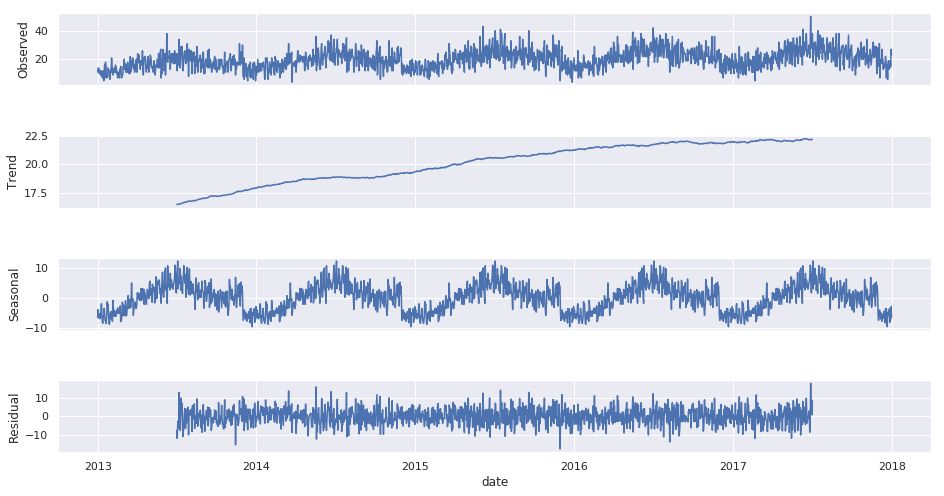

In [57]:
res = sm.tsa.seasonal_decompose(buf.sales.dropna(),freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Clearly,this data is growing(has a trend).

# Train & Test Data split

In [58]:
#train_test_split
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

each model has parameters.
- ARMA model:(p,q)
- ARIMA model:(p,d,q)
- SARIMA model:(p,d,q)(sp,sd,sq,s)
- ARIMAX model:(p,d,q) + exog
- SARIMAX model:(p,d,q)(sp,sd,sq,s) +exog

# Model choice

We choose a model after we comfirm that a data has a trend(is stationary) or not.  
For example, ARMA model is premised that the data is stationary.

We can use ADF-test to check stationary of the data.

In [59]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(buf['sales'].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.0761068899241534


In [60]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(buf['sales'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.2109276320438636e-23


It's important to choose carefully a period of the data which will be used in predicting. Because, The results depend on the period.

In [61]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(buf['sales']['2015-01-01':].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.5620643402533474


In [62]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(buf['sales']['2015-01-01':].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:4.530417561586523e-22


What is adfuller method parameter 'regression'?
- ’c’ : constant only (default)
- ’ct’ : constant and trend
- ’ctt’ : constant, and linear and quadratic trend
- ’nc’ : no constant, no trend 


Like the results above, When Original-data is not stationary and Diff-data is stationary,the time series is called unit root process.  
For unit root process, We use ARIMA or SARIMA model.

From results,we decided that original time series is not stationary    
We will try using ARIMA model.

# Correlograms

Autocorrelogram & Partial Autocorrelogram is used to estimate each models' parameters

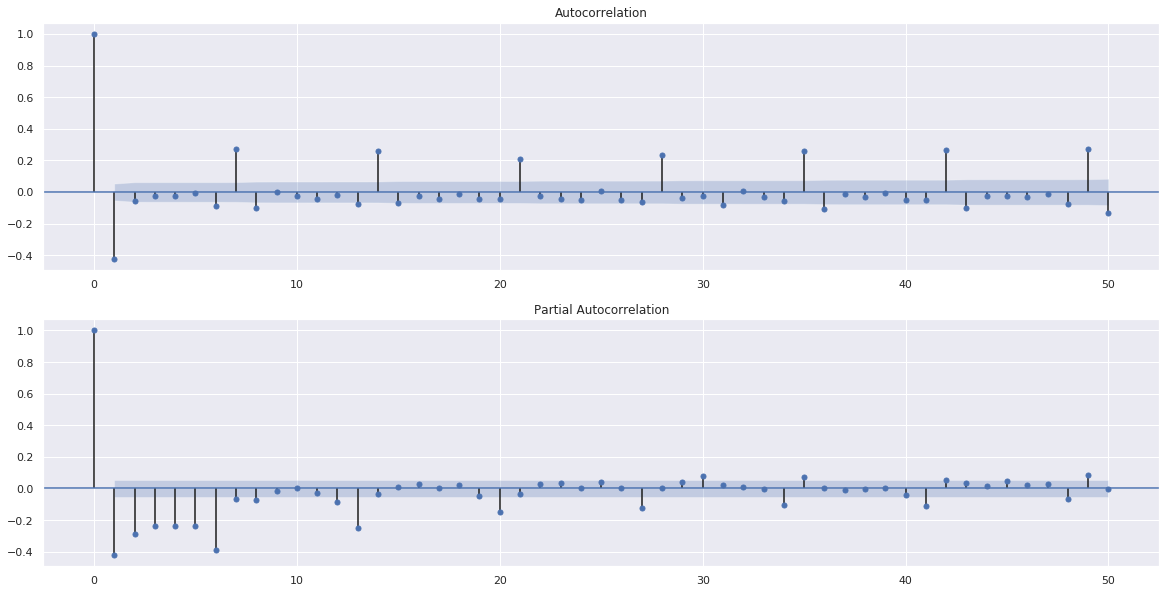

In [63]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From results,looks like ARIMA(p=7,d=1,q=?) model.

if we use arma_order_select_ic method, it searches best parameters(p,q) of ARMA model.

In [64]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


We got parameters (7,1,7).

# ARIMA model

In [65]:
arima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),freq='D',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -4069.311
Date:                Sat, 20 May 2023   AIC                           8168.622
Time:                        14:07:48   BIC                           8246.949
Sample:                    01-01-2014   HQIC                          8197.935
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8856      0.037    -23.744      0.000      -0.959      -0.812
ar.L2         -0.8922      0.036    -24.722      0.000      -0.963      -0.821
ar.L3         -0.8882      0.036    -24.349      0.000      -0.960      -0.817
ar.L4         -0.8842      0.037    -24.057      0.000      -0.956      -0.812
ar.L5         -0.8933      0.035    -25.288      0.000      -0.962      -0.824
ar.L6         -0.8830      0.037    -23.753      0.000      -0.956      -0.810
ar.L7          0.1037      0.035      2.944      0.003       0.035       0.173
ma.L1          0.0394      0.025      1.597      0.110      -0.009       0.088
ma.L2          0.0969      0.031      3.115      0.002       0.036       0.158
ma.L3          0.0365      0.027      1.357      0.175      -0.016       0.089
ma.L4          0.0566      0.026      2.163      0.031       0.005       0.108
ma.L5          0.1074      0.030      3.609      0.000       0.049       0.166
ma.L6          0.0670      0.024      2.765      0.006       0.020       0.115
ma.L7         -0.8485      0.030    -28.536      0.000      -0.907      -0.790
sigma2        24.8229      1.174     21.150      0.000      22.523      27.123
===================================================================================
Ljung-Box (Q):                       46.30   Jarque-Bera (JB):                 9.58
Prob(Q):                              0.23   Prob(JB):                         0.01
Heteroskedasticity (H):               1.35   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model's resid have few autocorrelation.  
It means that We were able to make a good model.

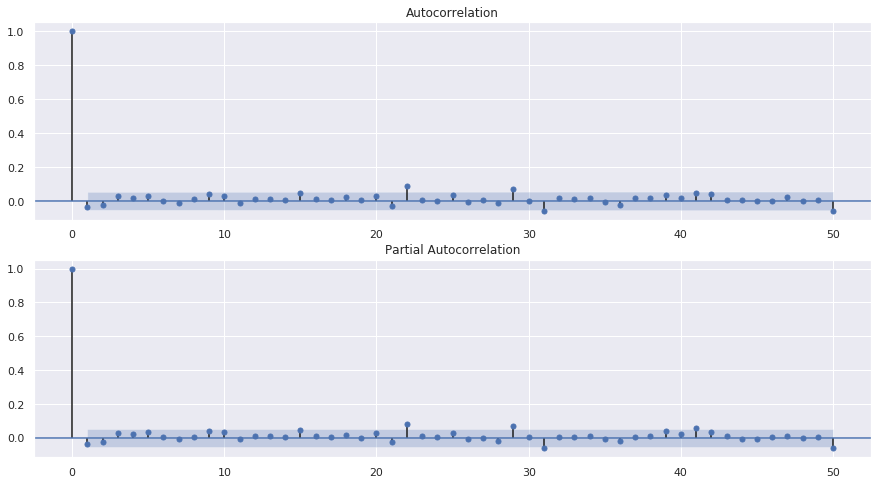

In [66]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:45.70733988293


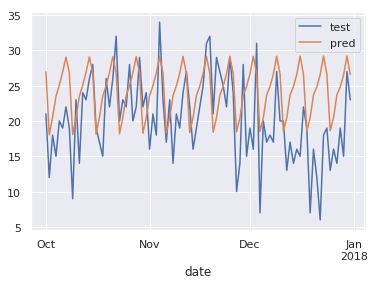

In [68]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

# SARIMA model

Estimating seasonal_order(sp,sd,sq,s) parameters.  
parameter s:
- 1 for yearly
- 4 for quarterly
- 12 for monthly
- 52 for weekly
- 365 for daily 



When we choose period 365,It will run out of memory.  
SARIMA model is unsuitable to solve this problem.  

For now,we choose period 1.

In [69]:
sarima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(7,1,7,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1369
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 1)   Log Likelihood               -4069.452
Date:                           Sat, 20 May 2023   AIC                           8196.905
Time:                                   14:08:00   BIC                           8348.338
Sample:                               01-01-2014   HQIC                          8253.577
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9163      0.700     -1.309      0.191      -2.289       0.456
ar.L2         -0.8558      0.701     -1.222      0.222      -2.229       0.517
ar.L3         -0.8954      0.648     -1.382      0.167      -2.165       0.374
ar.L4         -0.8668      0.658     -1.316      0.188      -2.157       0.424
ar.L5         -0.8951      0.621     -1.442      0.149      -2.112       0.321
ar.L6         -0.8360      0.639     -1.308      0.191      -2.089       0.417
ar.L7          0.0336      0.598      0.056      0.955      -1.138       1.205
ma.L1         -0.0795      0.024     -3.320      0.001      -0.126      -0.033
ma.L2         -0.0852      0.023     -3.632      0.000      -0.131      -0.039
ma.L3         -0.0621      0.026     -2.389      0.017      -0.113      -0.011
ma.L4         -0.0643      0.025     -2.555      0.011      -0.114      -0.015
ma.L5          0.0009      0.024      0.038      0.970      -0.046       0.048
ma.L6         -0.0419      0.026     -1.607      0.108      -0.093       0.009
ma.L7         -0.9388      0.024    -38.404      0.000      -0.987      -0.891
ar.S.L1       -0.9080      0.697     -1.303      0.192      -2.273       0.457
ar.S.L2       -0.8970      0.708     -1.267      0.205      -2.285       0.491
ar.S.L3       -0.8790      0.703     -1.251      0.211      -2.256       0.498
ar.S.L4       -0.8693      0.681     -1.277      0.202      -2.203       0.465
ar.S.L5       -0.8798      0.661     -1.331      0.183      -2.175       0.415
ar.S.L6       -0.8907      0.659     -1.351      0.177      -2.183       0.401
ar.S.L7        0.0902      0.671      0.135      0.893      -1.224       1.405
ma.S.L1       -0.0795      0.024     -3.320      0.001      -0.126      -0.033
ma.S.L2       -0.0852      0.023     -3.632      0.000      -0.131      -0.039
ma.S.L3       -0.0621      0.026     -2.389      0.017      -0.113      -0.011
ma.S.L4       -0.0643      0.025     -2.555      0.011      -0.114      -0.015
ma.S.L5        0.0009      0.024      0.038      0.970      -0.046       0.048
ma.S.L6       -0.0419      0.026     -1.607      0.108      -0.093       0.009
ma.S.L7       -0.9388      0.024    -38.403      0.000      -0.987      -0.891
sigma2        20.2449      0.864     23.423      0.000      18.551      21.939
===================================================================================
Ljung-Box (Q):                       44.38   Jarque-Bera (JB):                 7.15
Prob(Q):                              0.29   Prob(JB):                         0.03
Heteroskedasticity (H):               1.38   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covarianc

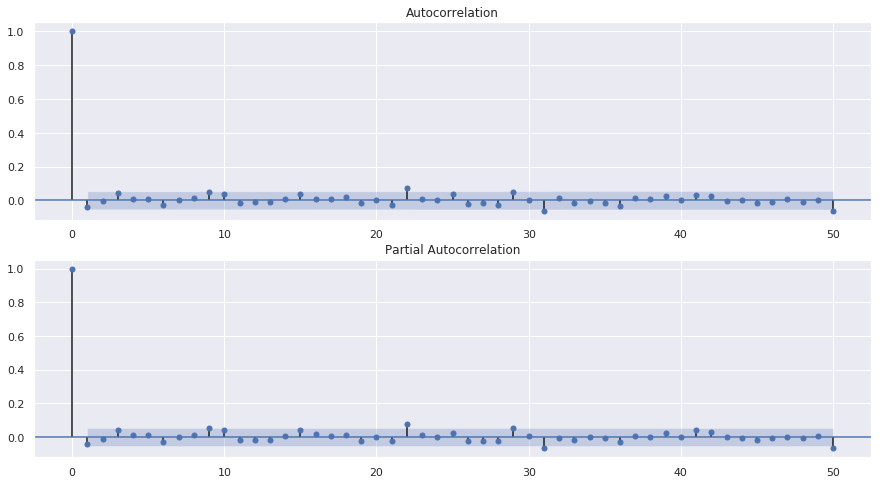

In [70]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMA model MSE:28.232220455874227


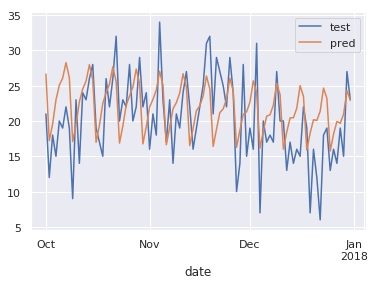

In [72]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

It seems that SARIMA model's prediction is better than ARIMA model's.

Next,We try ARIMAX and SARIMAX model 
ARIMAX(SARIMAX) is what added exogenous regressors to ARIMA(SARIMA) .

# Make features

Let's try to make some features
- month
- dayofweek
- sales_shifted_364(1year_shift)
- sales_shifted_728(2year_shift)

Sales group by month

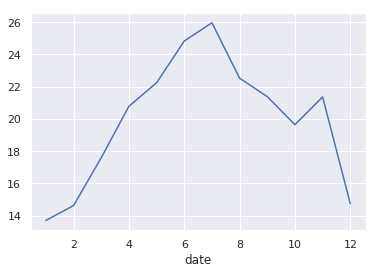

In [73]:
buf.groupby(buf.index.month).sales.mean().plot();plt.show()

Sales group by day of the week.

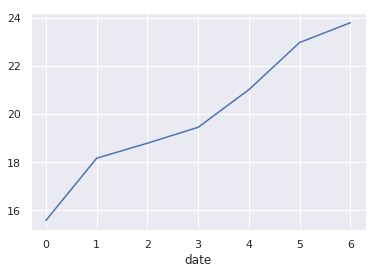

In [74]:
buf.groupby(buf.index.weekday).sales.mean().plot();plt.show()

The two data looks like the same.

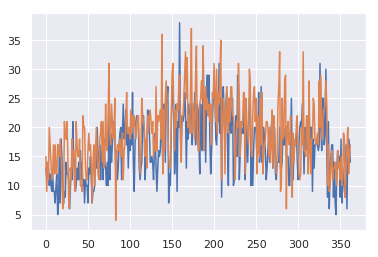

In [75]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values);plt.show()

In [76]:
buf = df[(df.item==1)&(df.store==1)].copy()#reset buf
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
buf = pd.concat([buf, month_dummies], axis=1, join_axes=[buf.index]).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1, join_axes=[buf.index]).drop(['dayofweek'],axis=1)
#Saturday,Sunday
buf['weekend'] = (buf.index.dayofweek>4).astype(int)#Saturday,Sunday
#Sunday
#buf['sunday'] = (buf.index.dayofweek==6).astype(int)#Saturday,Sunday

In [77]:
#shifted data
#buf['sales_shifted_91'] = buf.sales.shift(91)
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [78]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end].dropna()

# ARIMAX model

In [79]:
arimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2957.328
Date:                Sat, 20 May 2023   AIC                           5988.656
Time:                        14:08:17   BIC                           6170.391
Sample:                    01-01-2015   HQIC                          6057.715
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.7265      1.143     -3.259      0.001      -5.967      -1.486
month-2              -3.4561      1.095     -3.156      0.002      -5.603      -1.310
month-3              -2.0299      0.998     -2.034      0.042      -3.986      -0.074
month-4              -0.4956      0.889     -0.558      0.577      -2.237       1.246
month-5               0.1764      0.957      0.184      0.854      -1.699       2.052
month-6               1.3741      1.015      1.354      0.176      -0.614       3.363
month-7               2.9869      1.083      2.757      0.006       0.864       5.110
month-8               1.3803      0.961      1.436      0.151      -0.503       3.264
month-9               3.0379      0.904      3.361      0.001       1.266       4.809
month-10              2.7809      1.073      2.593      0.010       0.679       4.883
month-11              1.9911      1.132      1.760      0.078      -0.227       4.209
month-12             -4.0195      1.123     -3.579      0.000      -6.221      -1.818
dayofweek-0          -3.5749      0.456     -7.843      0.000      -4.468      -2.681
dayofweek-1          -0.7116      0.405     -1.756      0.079      -1.506       0.083
dayofweek-2          -0.3530      0.369     -0.957      0.338      -1.076       0.370
dayofweek-3           0.1965      0.394      0.498      0.618      -0.576       0.969
dayofweek-4           1.7070      0.372      4.591      0.000       0.978       2.436
dayofweek-5           1.0420      0.295      3.536      0.000       0.464       1.619
dayofweek-6           1.6938      0.322      5.261      0.000       1.063       2.325
weekend               2.7357      0.237     11.556      0.000       2.272       3.200
sales_shifted_728     0.0540      0.036      1.519      0.129      -0.016       0.124
sales_shifted_364     0.0518      0.034      1.524      0.127      -0.015       0.118
ar.L1                -0.3109      3.498     -0.089      0.929      -7.168       6.546
ar.L2                 0.6372      0.891      0.715      0.475      -1.110       2.384
ar.L3                -0.0655      1.841     -0.036      0.972      -3.674       3.543
ar.L4                -0.2955      0.970     -0.305      0.761      -2.196       1.605
ar.L5                 0.2166      0.655      0.331      0.741      -1.066       1.500
ar.L6                 0.0610      1.101      0.055      0.956      -2.097       2.219
ar.L7                -0.0301      0.188     -0.160      0.873      -0.398       0.338
ma.L1                -0.8608      3.310     -0.260      0.795      -7.348       5.627
ma.L2                -1.0411      3.903     -0.267      0.790      -8.691       6.609
ma.L3                 0.8201      2.185      0.375      0.707      -3.463       5.103
ma.L4                 0.2910      2.797      0.104      0.917      -5.191       5.773
ma.L5                -0.5167      1.143     -0.452      0.651      -2.756       1.723
ma.L6                 0.1170      1.331      0.088      0.9

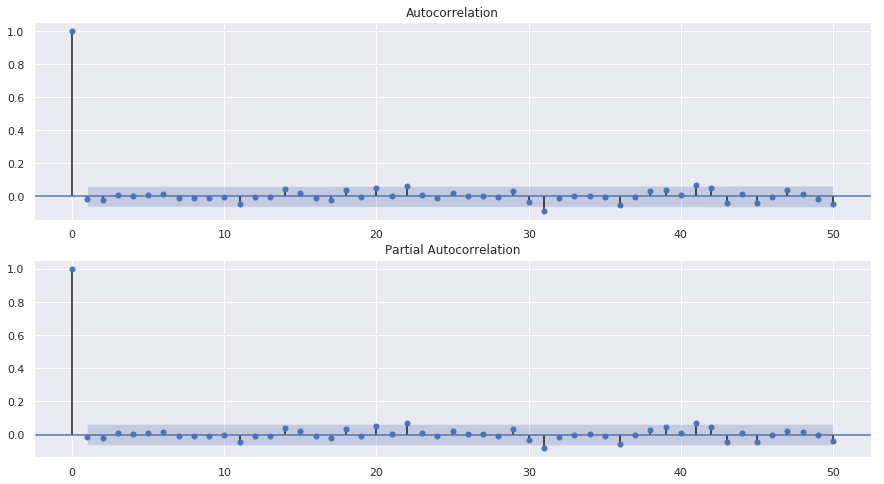

In [80]:
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
pred = arimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:23.456569898566915


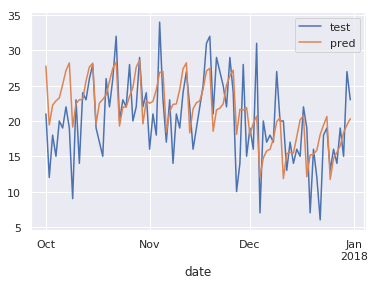

In [82]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

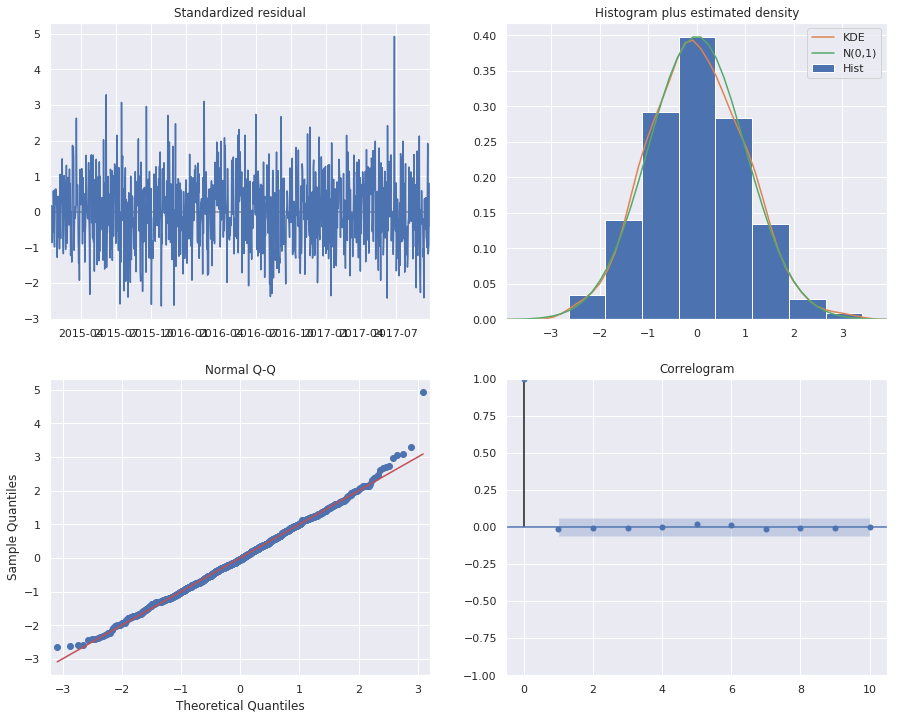

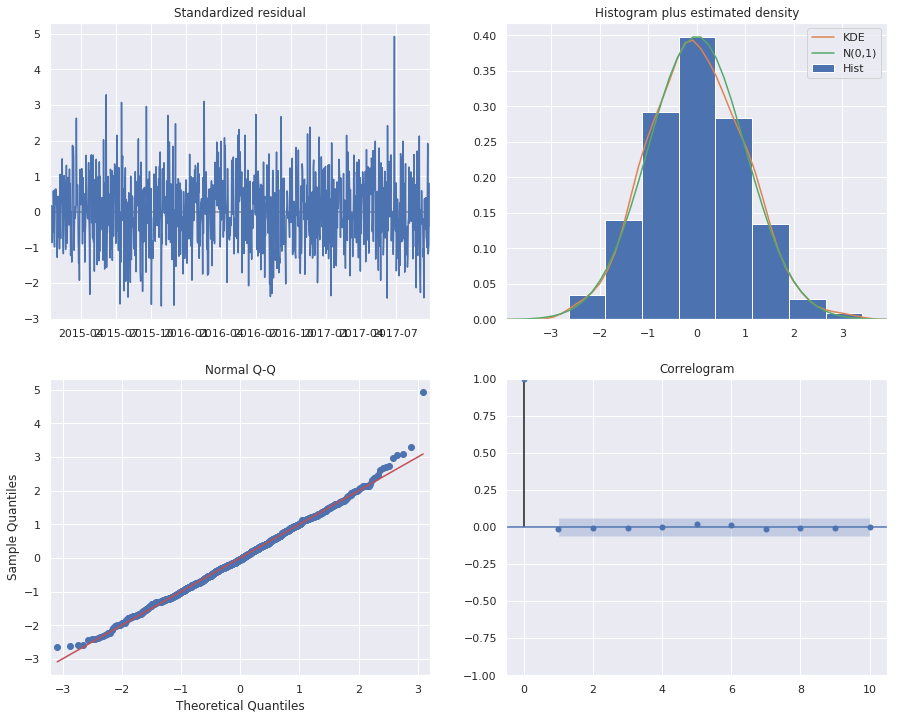

In [83]:
arimax.plot_diagnostics(figsize=(15, 12))

# SARIMAX model

In [84]:
sarimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(1,0,5,1),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1004
Model:             SARIMAX(7, 1, 7)x(1, 0, 5, 1)   Log Likelihood               -2949.046
Date:                           Sat, 20 May 2023   AIC                           5984.092
Time:                                   14:08:41   BIC                           6195.297
Sample:                               01-01-2015   HQIC                          6064.349
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.4792      1.215     -2.863      0.004      -5.861      -1.097
month-2              -3.5068      1.162     -3.019      0.003      -5.784      -1.230
month-3              -1.9735      1.067     -1.849      0.064      -4.065       0.118
month-4              -0.4306      0.963     -0.447      0.655      -2.318       1.457
month-5              -0.1084      1.035     -0.105      0.917      -2.138       1.921
month-6               1.2486      1.063      1.174      0.240      -0.835       3.332
month-7               2.8574      1.128      2.532      0.011       0.646       5.069
month-8               1.3679      1.008      1.357      0.175      -0.608       3.344
month-9               3.1271      0.972      3.217      0.001       1.222       5.032
month-10              3.2156      1.185      2.713      0.007       0.893       5.538
month-11              1.7468      1.218      1.434      0.152      -0.641       4.135
month-12             -4.0648      1.209     -3.362      0.001      -6.434      -1.695
dayofweek-0          -3.6715      0.458     -8.012      0.000      -4.570      -2.773
dayofweek-1          -0.5155      0.390     -1.322      0.186      -1.280       0.249
dayofweek-2          -0.3299      0.358     -0.922      0.356      -1.031       0.371
dayofweek-3           0.1582      0.382      0.414      0.679      -0.590       0.907
dayofweek-4           1.6579      0.367      4.517      0.000       0.939       2.377
dayofweek-5           1.0235      0.282      3.624      0.000       0.470       1.577
dayofweek-6           1.6772      0.309      5.432      0.000       1.072       2.282
weekend               2.7007      0.242     11.169      0.000       2.227       3.175
sales_shifted_728     0.0410      0.037      1.105      0.269      -0.032       0.114
sales_shifted_364     0.0661      0.036      1.861      0.063      -0.004       0.136
ar.L1                 0.0774      3.193      0.024      0.981      -6.181       6.336
ar.L2                -0.8927      3.439     -0.260      0.795      -7.633       5.847
ar.L3                 0.0849      5.699      0.015      0.988     -11.085      11.255
ar.L4                 0.3897      5.789      0.067      0.946     -10.956      11.736
ar.L5                -0.3580      4.195     -0.085      0.932      -8.580       7.864
ar.L6                 0.3551      2.386      0.149      0.882      -4.322       5.032
ar.L7                -0.2721      1.397     -0.195      0.846      -3.010       2.466
ma.L1                -0.4349      3.925     -0.111      0.912      -8.128       7.258
ma.L2                -0.1819      1.434     -0.127      0.899      -2.992       2.628
ma.L3                -0.0818      1.697     -0.048      0.962      -3.408       3.244
ma.L4                -0.6672      1.266     -0.527      0.598      -3.148       1.813
ma.L5                 0.4351      2.851      0

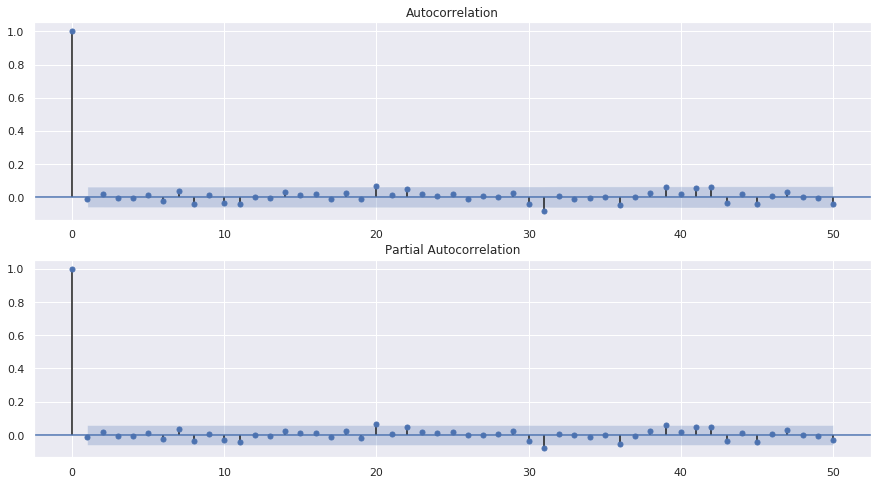

In [85]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error
pred = sarimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:24.137310612183995


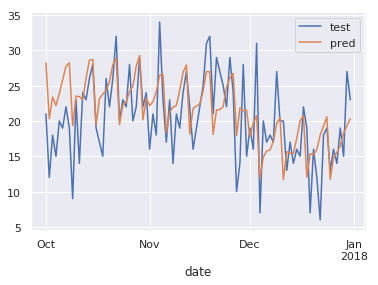

In [87]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

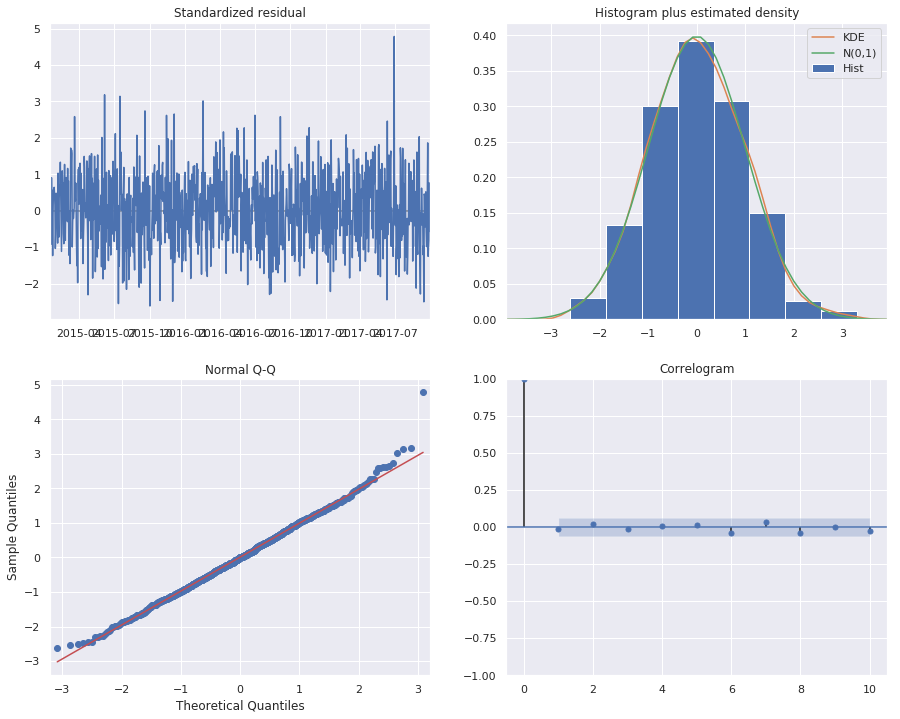

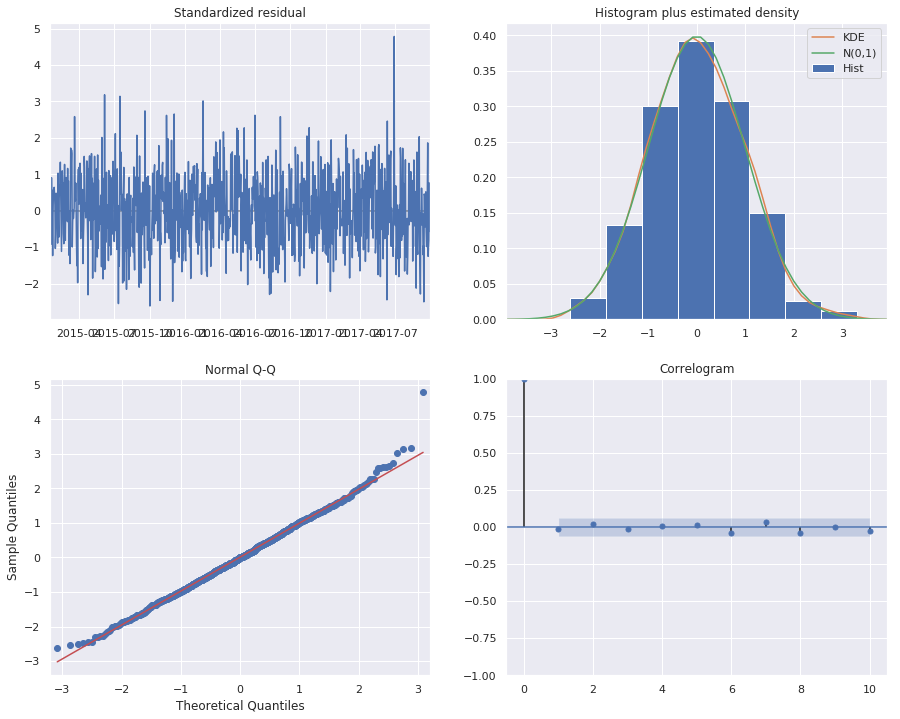

In [88]:
sarimax.plot_diagnostics(figsize=(15, 12))

It seems that ARIMAX model's prediction is better than SARIMAX model's.  
And  because SARIMA(X) model has a issue(seasonal period parameter),we choose ARIMAX model.

# ARIMAX Model's summary check

The results of Jarque-Bera test and Ljung-Box test provide an indication of the validity of this model.
 
 In this model's summary, Jarque-Bera test's Probability is under 0.05
 It means that this model's residual is not following a normal distribution  
 In other words, some infomation still remains in this model's residual  
 
The histgram from plot_diagnostics method looks like slightly skewed

Ljung-Box test

Jarque-Bera test


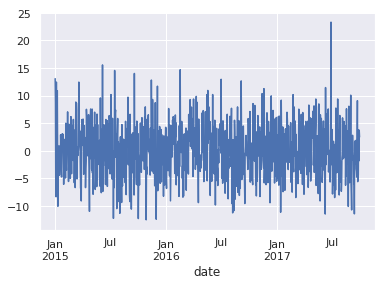

In [89]:
arimax.resid.plot();plt.show()

It seems that there is outlier in this model's residual in late June.

In [90]:
res_df = pd.DataFrame(arimax.resid,columns=['resid'])
res_df.sort_values(by='resid',ascending=False).head(5)

,resid
date,
2017-06-28,23.269560
2015-06-06,15.533049
2016-02-17,14.660131
2015-07-16,14.529288
2015-09-19,13.992734


The outlier is the sales in '2017-06-28'.  
What is its importance?

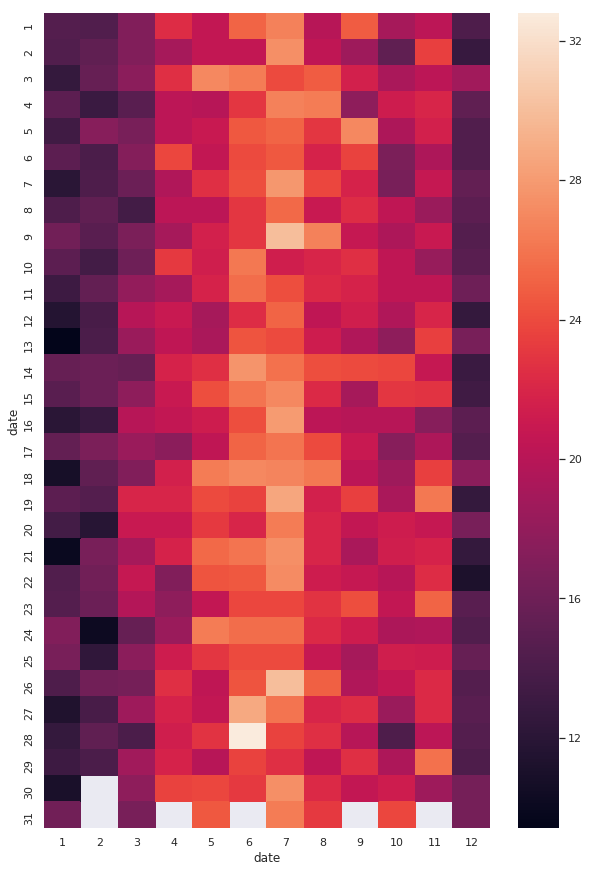

In [91]:
plt.figure(figsize=(10,15))
piv_val = buf.pivot_table(values='sales',
                          index=buf.index.day,
                          columns=buf.index.month,
                          aggfunc='mean')
sns.heatmap(piv_val)
plt.show()

In [92]:
buf[(buf.index.day == 28)&(buf.index.month == 6)]['sales']

date
2013-06-28    17.0
2014-06-28    34.0
2015-06-28    35.0
2016-06-28    28.0
2017-06-28    50.0
Name: sales, dtype: float64

28th June 2017's sales is much larger that 28th June sales of other years   
Besides, that one day is a weekday.

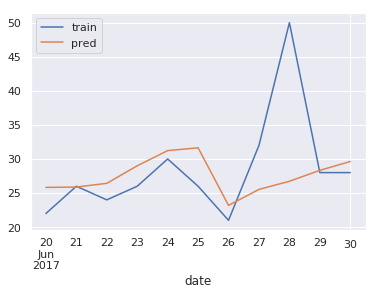

In [93]:
#traindata predict
pred = arimax.predict(tr_start,tr_end,exog = exog_train)[1:]
pd.DataFrame({'train':tra['2017-06-20':'2017-06-30'],
              'pred':pred['2017-06-20':'2017-06-30']}).plot();plt.show()

# New features

In [94]:
#outlier etc...
buf['outlier_flag']=0
buf.loc[buf.index == '2017-06-28','outlier_flag']=1

In [95]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [96]:
arimax_2 = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
arimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2942.172
Date:                Sat, 20 May 2023   AIC                           5960.343
Time:                        14:09:00   BIC                           6146.990
Sample:                    01-01-2015   HQIC                          6031.268
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -4.3157      1.077     -4.008      0.000      -6.426      -2.205
month-2              -3.4274      1.047     -3.272      0.001      -5.480      -1.375
month-3              -2.5239      0.928     -2.720      0.007      -4.343      -0.705
month-4              -0.1270      0.831     -0.153      0.878      -1.755       1.501
month-5               0.4209      0.907      0.464      0.643      -1.357       2.198
month-6               1.6375      0.977      1.676      0.094      -0.278       3.553
month-7               3.6117      1.025      3.523      0.000       1.602       5.621
month-8               1.5332      0.906      1.691      0.091      -0.243       3.310
month-9               2.7007      0.828      3.262      0.001       1.078       4.323
month-10              2.1498      0.982      2.189      0.029       0.225       4.074
month-11              2.2971      1.067      2.153      0.031       0.206       4.388
month-12             -3.9570      1.078     -3.672      0.000      -6.069      -1.845
dayofweek-0          -3.5301      0.449     -7.871      0.000      -4.409      -2.651
dayofweek-1          -1.1513      0.396     -2.906      0.004      -1.928      -0.375
dayofweek-2          -0.4755      0.376     -1.264      0.206      -1.212       0.262
dayofweek-3           0.1362      0.380      0.358      0.720      -0.609       0.881
dayofweek-4           1.9147      0.369      5.195      0.000       1.192       2.637
dayofweek-5           1.4128      0.287      4.922      0.000       0.850       1.975
dayofweek-6           1.6929      0.316      5.366      0.000       1.075       2.311
weekend               3.1058      0.231     13.466      0.000       2.654       3.558
sales_shifted_728     0.0206      0.035      0.586      0.558      -0.048       0.089
sales_shifted_364     0.0432      0.034      1.283      0.200      -0.023       0.109
outlier_flag         20.5118      6.256      3.279      0.001       8.251      32.772
ar.L1                -0.5477      1.028     -0.532      0.594      -2.563       1.468
ar.L2                 0.2544      0.962      0.264      0.792      -1.632       2.140
ar.L3                 0.1981      0.928      0.213      0.831      -1.622       2.018
ar.L4                 0.1130      0.640      0.177      0.860      -1.141       1.367
ar.L5                -0.1549      0.482     -0.321      0.748      -1.100       0.790
ar.L6                -0.3438      0.377     -0.912      0.362      -1.083       0.395
ar.L7                -0.0301      0.075     -0.401      0.688      -0.177       0.117
ma.L1                -0.4138      1.027     -0.403      0.687      -2.427       1.599
ma.L2                -0.8018      0.879     -0.912      0.362      -2.525       0.922
ma.L3                 0.0377      0.834      0.045      0.964      -1.598       1.673
ma.L4                 0.0874      0.677      0.129      0.897      -1.239       1.414
ma.L5                 0.3350      0.647      0.518      0.6

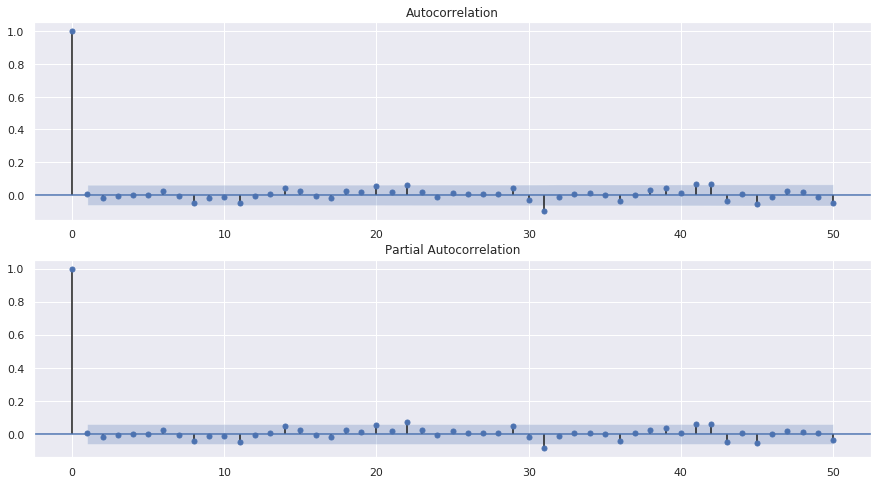

In [97]:
res = arimax_2.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error
pred = arimax_2.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:24.089975570796717


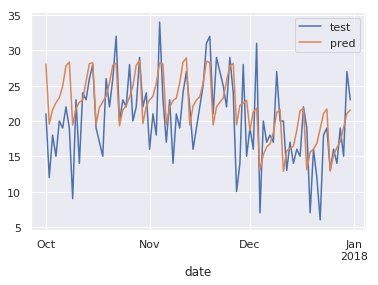

In [99]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

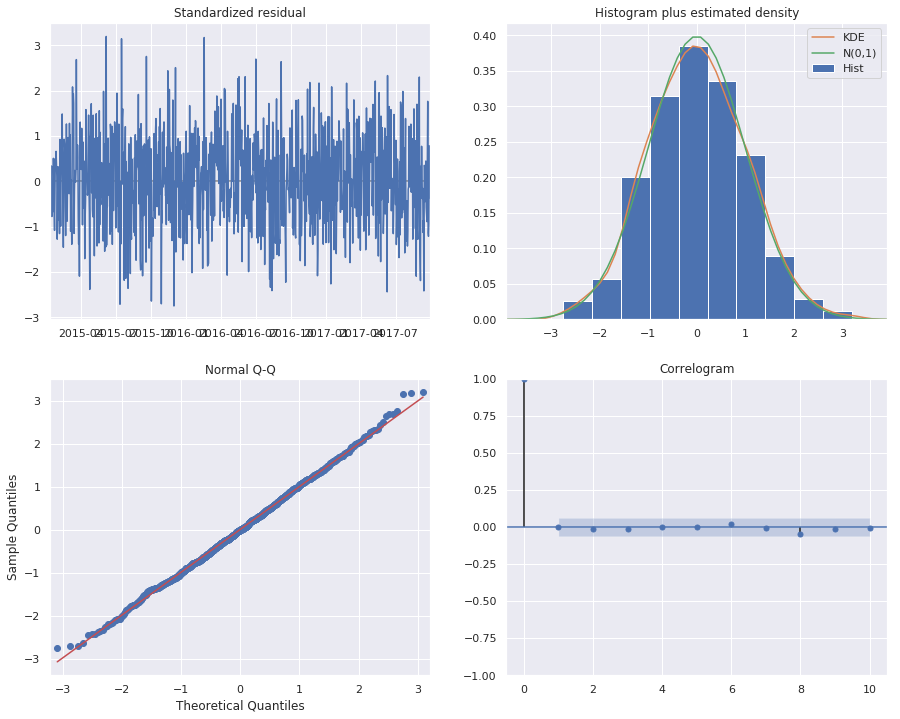

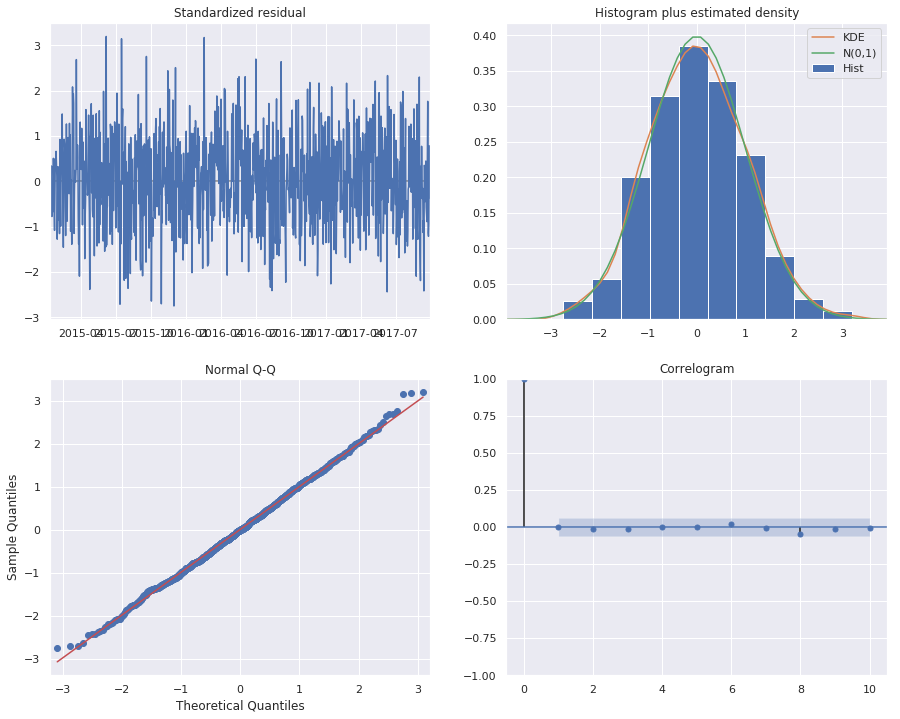

In [100]:
arimax_2.plot_diagnostics(figsize=(15, 12))

The histogram still looks skewed, but Jarque-Bera test's Prob is over 0.05  
It means that this model's residual follows a normal distribution    

An added feature was useless to increase prediction accuracy
But, we were able to make a better model

# Search best parameters

We can search best parameters of SARIMAX

In [101]:
import itertools
from sklearn.metrics import mean_squared_error

p = q = range(7,8)
pdq = list(itertools.product(p, [1], q))
sp = sq = range(1,8)#range(0,1) <- ARIMAX
seasonal_pdq = list(itertools.product(sp, [0,1], sq,[1]))#rlist(itertools.product(sp, [0], sq,[0]))<- ARIMAX

params = []
params_s = []
aics = []
mses = []
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:

        try:
            mod = sm.tsa.statespace.SARIMAX(tra,
                                            order=param,
                                            exog = exog_train,
                                            seasonal_order=param_seasonal,
                                            freq='D',
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            pred = results.get_prediction(start = pd.to_datetime(tr_end),
                                      end = pd.to_datetime(te_end),exog=exog_test)

            params.append(param)
            params_s.append(param_seasonal)
            aics.append(results.aic)
            mses.append(mean_squared_error(tes,pred.predicted_mean[1:]))


            #if cnt % 8 == 0:
            print('SARIMAX{}x{} - AIC:{} - MSE:{}'.format(param,
                                                            param_seasonal,
                                                            results.aic,
                                                        mses[-1]))
                #cnt += 1

        except:
            continue

min_ind = aics.index(min(aics))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_aic:',bestparam,' aic:',min(aics))
min_ind = mses.index(min(mses))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_mse:',bestparam,' mse:',min(mses))

print('Finish!!')

SARIMAX(7, 1, 7)x(1, 0, 1, 1) - AIC:5976.565010317924 - MSE:24.095274679789817
SARIMAX(7, 1, 7)x(1, 0, 2, 1) - AIC:6054.929834946966 - MSE:32.24388392502069
SARIMAX(7, 1, 7)x(1, 0, 3, 1) - AIC:6060.086211055972 - MSE:32.64480403732549
SARIMAX(7, 1, 7)x(1, 0, 4, 1) - AIC:6020.186627212118 - MSE:28.559899679501154
SARIMAX(7, 1, 7)x(1, 0, 5, 1) - AIC:6002.8716670059885 - MSE:27.88898901282593
SARIMAX(7, 1, 7)x(1, 0, 6, 1) - AIC:6009.393253023705 - MSE:28.42957101325568
SARIMAX(7, 1, 7)x(1, 0, 7, 1) - AIC:5970.831754744624 - MSE:26.665358441642866
SARIMAX(7, 1, 7)x(1, 1, 1, 1) - AIC:6145.8448650175305 - MSE:57.37434070542605
SARIMAX(7, 1, 7)x(1, 1, 2, 1) - AIC:6164.92028914683 - MSE:58.54250070789373
SARIMAX(7, 1, 7)x(1, 1, 3, 1) - AIC:6171.779525251807 - MSE:67.83273092078961
SARIMAX(7, 1, 7)x(1, 1, 4, 1) - AIC:6159.6830583866 - MSE:62.60444638346985
SARIMAX(7, 1, 7)x(1, 1, 5, 1) - AIC:6155.975511861074 - MSE:61.28275113653114
SARIMAX(7, 1, 7)x(1, 1, 6, 1) - AIC:6136.274781984132 - MSE:57

# Submit Prediction

In [102]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')

In [103]:
#month one hot encoding
df['month'] = df.index.month
month_dummies = pd.get_dummies(df['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df = pd.concat([df, month_dummies], axis=1, join_axes=[df.index]).drop(['month'],axis=1)
#dayofweek one hot encoding
df['dayofweek'] = df.index.weekday
week_dummies = pd.get_dummies(df['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df = pd.concat([df, week_dummies], axis=1, join_axes=[df.index]).drop(['dayofweek'],axis=1)
#Satday,Sunday
df['weekend'] = (df.index.dayofweek>4).astype(int)#Satday,Sunday

#shifts
shifts = [364,728]
for s in shifts:
    df['store_item_shifted-'+str(s)] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(s))

In [104]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,11):
        buf = df[(df.item==i)&(df.store==s)].copy()
        #buf['sales_shifted_728'] = buf.sales.shift(728)
        #buf['sales_shifted_364'] = buf.sales.shift(364)
        #target_exog = buf[~buf.id.isnull()].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        #exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end]#.dropna()
        
        #fitting
        mod = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)#pd.concat([exog_test,target_exog]))
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.
item: 1 store: 2 Finished.
item: 1 store: 3 Finished.
item: 1 store: 4 Finished.
item: 1 store: 5 Finished.
item: 1 store: 6 Finished.
item: 1 store: 7 Finished.
item: 1 store: 8 Finished.
item: 1 store: 9 Finished.
item: 1 store: 10 Finished.
item: 2 store: 1 Finished.
item: 2 store: 2 Finished.
item: 2 store: 3 Finished.
item: 2 store: 4 Finished.
item: 2 store: 5 Finished.
item: 2 store: 6 Finished.
item: 2 store: 7 Finished.
item: 2 store: 8 Finished.
item: 2 store: 9 Finished.
item: 2 store: 10 Finished.
item: 3 store: 1 Finished.
item: 3 store: 2 Finished.
item: 3 store: 3 Finished.
item: 3 store: 4 Finished.
item: 3 store: 5 Finished.
item: 3 store: 6 Finished.
item: 3 store: 7 Finished.
item: 3 store: 8 Finished.
item: 3 store: 9 Finished.
item: 3 store: 10 Finished.
item: 4 store: 1 Finished.
item: 4 store: 2 Finished.
item: 4 store: 3 Finished.
item: 4 store: 4 Finished.
item: 4 store: 5 Finished.
item: 4 store: 6 Finished.
item: 4 store: 7 Finished

In [105]:
sample['sales'] = results
sample.to_csv('submission.csv',index=False)

In [106]:
sample.head()

,id,sales
0,0,12.453413
1,1,14.995405
2,2,15.898259
3,3,16.161029
4,4,18.253575


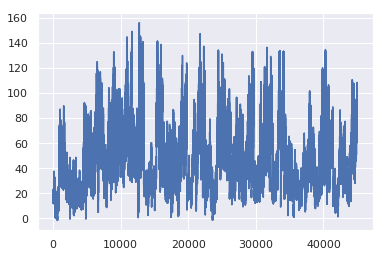

In [116]:
plt.plot(sample['id'],sample['sales'])